<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Pasrt 4a: Prelimary Test PyCaret</font></h1>
<h1 align=center><font size = 3> ERCE 2021 - 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html


#### Libraries

In [2]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [3]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()


,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,AFRICA,ABU GHARADIG,140.0,ONSHORE,232.0,4500.000000,GAS DRIVE,9350.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.10,21.0,140.00,40.5,13.810000,850.0,166.0,19.0,2
1,AFRICA,ABU GHARADIG,140.0,ONSHORE,250.0,4600.000000,GAS DRIVE,9650.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.07,16.0,140.00,40.0,4.740000,800.0,214.0,14.0,2
2,MIDDLE EAST,ZAGROS,0.0,ONSHORE,190.0,4452.278385,AQUIFER DRIVE,7500.0,20.0,NEOGENE/PALEOGENE,...,LAYER-CAKE,0.36,19.0,385.00,32.6,0.580000,950.0,57300.0,44.3,3
3,MIDDLE EAST,SOUTH OMAN SALT,62.0,ONSHORE,212.0,11600.000000,GAS DRIVE,12140.0,10.0,CAMBRIAN/PROTEROZOIC,...,LAYER-CAKE,0.68,17.0,0.01,48.0,0.135469,410.0,1321.0,7.0,4
4,EUROPE,NORTH SEA CENTRAL,0.0,OFFSHORE,172.0,2850.000000,GAS DRIVE,6102.0,1.5,PALEOGENE,...,TANK LIKE,0.80,35.0,3000.00,19.5,7.000000,246.0,1000.0,44.0,7


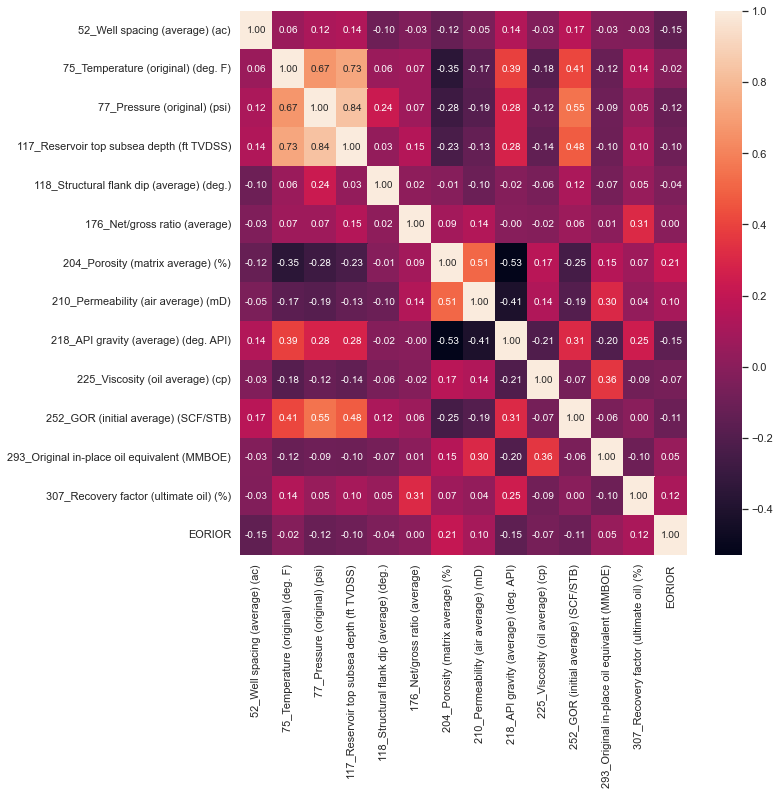

In [5]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As the variable "117_Reservoir top subsea depth" does not add any additional information when it comes to predictive modelleing, this variable will be dropped, and the the heat map recreated to check for correlation again.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

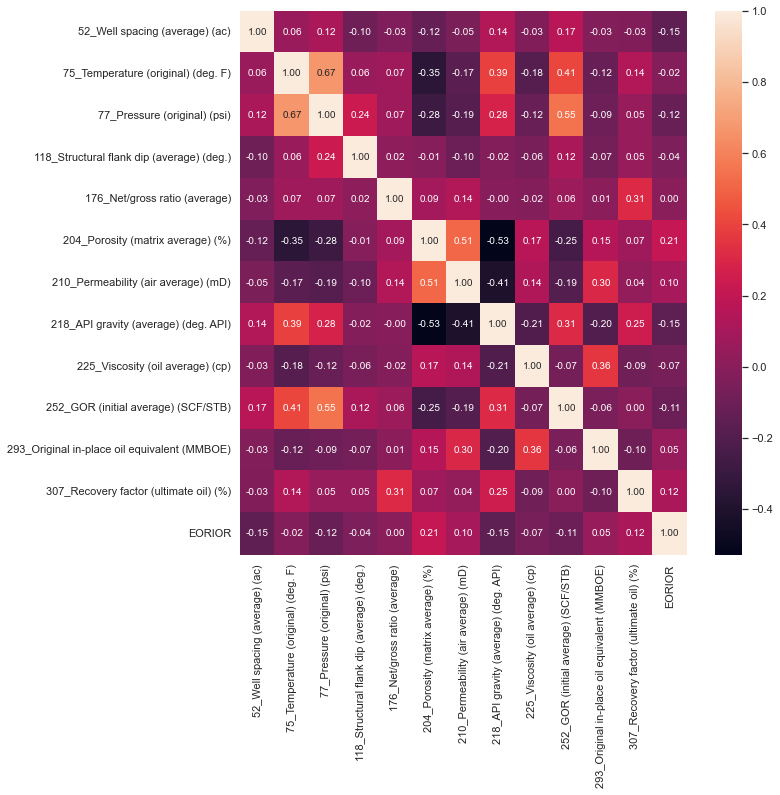

In [6]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

In [7]:
# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

436
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   10_Region                                     436 non-null    object 
 1   11_Basin name                                 436 non-null    object 
 2   52_Well spacing (average) (ac)                436 non-null    float64
 3   72_Onshore or offshore                        436 non-null    object 
 4   75_Temperature (original) (deg. F)            436 non-null    float64
 5   77_Pressure (original) (psi)                  436 non-null    float64
 6   82_Drive mechanism (main)                     436 non-null    object 
 7   118_Structural flank dip (average) (deg.)     436 non-null    float64
 8   149_Reservoir period                          436 non-null    object 
 9   153_Depositional system (main)                436 non-null   

In [8]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = '307_Recovery factor (ultimate oil) (%)'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            ignore_low_variance=True,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,307_Recovery factor (ultimate oil) (%)
2,Original Data,"(436, 20)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(305, 164)"


In [ ]:
best = compare_models()

In [ ]:
top3 = compare_models(include=['rf', 'gbr', 'catboost'], sort='MAE')

In [ ]:
print(best)

In [ ]:
#evaluate_model(best)

In [ ]:
rf = create_model('rf')
print(rf)

In [ ]:
tuned_rf = tune_model(rf, optimize = 'MSE')
print(tuned_rf)

In [ ]:
tuned_rf1 = tune_model(rf, optimize = 'MSE', n_iter = 50)
print(tuned_rf1)

In [ ]:
tuned_rf2 = tune_model(rf, optimize = 'RMSE', n_iter = 50)
print(tuned_rf2)

In [ ]:
tuned_rf3 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)

In [ ]:
tuned_rf4 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MAE", n_iter=50)

In [ ]:
print(tuned_rf3)
print(tuned_rf4)

In [ ]:
tuned_rf5 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="optuna", optimize="MAE", n_iter=50)
print(tuned_rf5)

In [ ]:
tuned_rf6 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="optuna", optimize="R2", n_iter=50)
print(tuned_rf6)

In [ ]:
tuned_rf7 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="optuna", optimize="RMSE", n_iter=50)
print(tuned_rf7)

In [ ]:
print(rf)

In [ ]:
rf_params = {'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]}

In [ ]:
tuned_rf2 = tune_model(rf, optimize = 'R2', custom_grid = rf_params)
print(tuned_rf2)

In [ ]:
gbr = create_model('gbr')
print(gbr)

In [ ]:
tuned_gbr = tune_model(gbr, optimize = 'MAE')
print(tuned_gbr)

In [ ]:
tuned_gbr1 = tune_model(gbr, optimize = 'R2')
print(tuned_gbr1)

In [ ]:
lightgbm = create_model('lightgbm')
print(lightgbm)

In [ ]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'MAE')

In [ ]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }
tuned_lightgbm2 = tune_model(lightgbm, custom_grid = lgbm_params)

In [ ]:
plot_model(tuned_rf)

In [ ]:
plot_model(tuned_rf, plot = 'error')

In [ ]:
#https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
plot_model(top3_none, plot = 'residuals_interactive')

In [ ]:
model_eval_dfs = []

In [ ]:
rf_none = create_model('rf')
rf_none = tune_model(rf_none, optimize='MSE')
rf_none_metrics = pull()
rf_none_df = rf_none_metrics.iloc[10:11]
#rf_none_df[['model', 'resampling']] = ['rf', 'none']
model_eval_dfs.append(rf_none_df)
rf_none_df